In [8]:
%load_ext autoreload
%autoreload 2
from helper import create_tsp_graph,plot_tsp_graph,bitstring_to_path,cost
from classical import solve_tsp_classical
from alternating_operator import get_expectation,analyse_result,create_qaoa_circ
from scipy.optimize import minimize
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile,Aer
from qaoa import get_expectation_qaoa,create_classical_qaoa_circ
import pickle

In [112]:
reps = 1
ncities = 5

In [113]:
G = create_tsp_graph(ncities)

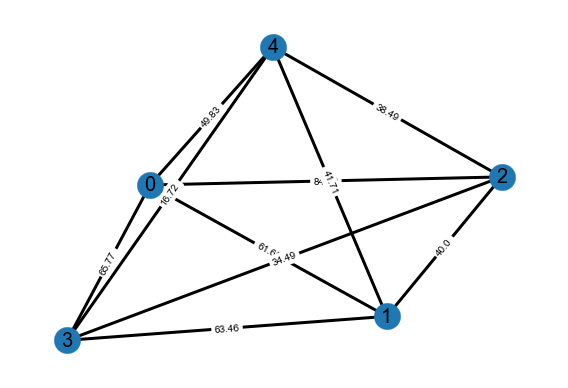

In [114]:
plot_tsp_graph(G)

In [115]:
expectation = get_expectation(G,reps,shots=1024,log_intermediate_counts=True)

res = minimize(expectation,
               [np.random.rand()*3 for _ in range(reps*4)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True,'maxiter':100})

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


Current expected cost: 232.3
Current expected cost: 232.3
Current expected cost: 232.3
Current expected cost: 202.72
Current expected cost: 202.72
Current expected cost: 235.02
Current expected cost: 214.54
Current expected cost: 202.72
Current expected cost: 207.66
Current expected cost: 239.2
Current expected cost: 207.07
Current expected cost: 202.72
Current expected cost: 208.74
Current expected cost: 221.9
Current expected cost: 219.15
Current expected cost: 202.72
Current expected cost: 202.69
Current expected cost: 235.15
Current expected cost: 202.69
Current expected cost: 235.77
Current expected cost: 202.69
Current expected cost: 235.15
Current expected cost: 215.05
Current expected cost: 207.82
Current expected cost: 202.95
Current expected cost: 210.51
Current expected cost: 203.44
Current expected cost: 202.69
Current expected cost: 204.13
Current expected cost: 202.69
Current expected cost: 204.68
Current expected cost: 203.22
Current expected cost: 202.85
Current expecte

In [116]:
with open(".\data\G", "wb") as fp:   #Pickling
    pickle.dump(G,fp)

In [117]:
res

     fun: 202.6891601407598
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 42
  status: 1
 success: True
       x: array([1.59685085, 2.46859275, 1.86549917, 0.56560584])

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


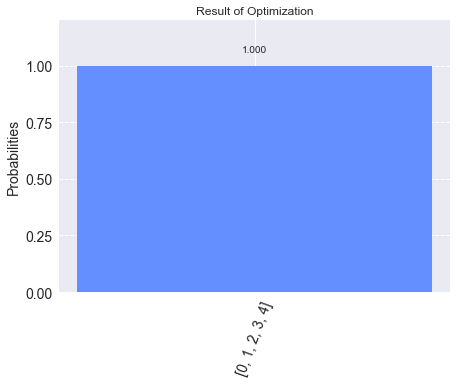

In [118]:
fig,counts = analyse_result(G,res.x,reps=reps,transform_labels_to_path=True,filter_unique_path=True)
fig

In [120]:
for key, val in counts.items():
    if val>1:
        path = bitstring_to_path(key)
        print(path,':', val , f"   cost = {round(cost(G,path),2)}")

[0, 1, 2, 3, 4] : 1024    cost = 202.69


In [9]:
from itertools import permutations
for p in permutations([0,1,2,3]):
    print(p,':',cost(G,p))

(0, 1, 2, 3) : 183.79577039525228
(0, 1, 3, 2) : 240.2901265500841
(0, 2, 1, 3) : 282.1419518766385
(0, 2, 3, 1) : 240.2901265500841
(0, 3, 1, 2) : 282.1419518766385
(0, 3, 2, 1) : 183.7957703952523
(1, 0, 2, 3) : 240.29012655008412
(1, 0, 3, 2) : 183.7957703952523
(1, 2, 0, 3) : 282.1419518766385
(1, 2, 3, 0) : 183.7957703952523
(1, 3, 0, 2) : 282.1419518766385
(1, 3, 2, 0) : 240.2901265500841
(2, 0, 1, 3) : 240.2901265500841
(2, 0, 3, 1) : 282.1419518766385
(2, 1, 0, 3) : 183.7957703952523
(2, 1, 3, 0) : 282.1419518766385
(2, 3, 0, 1) : 183.7957703952523
(2, 3, 1, 0) : 240.2901265500841
(3, 0, 1, 2) : 183.7957703952523
(3, 0, 2, 1) : 282.1419518766385
(3, 1, 0, 2) : 240.2901265500841
(3, 1, 2, 0) : 282.1419518766385
(3, 2, 0, 1) : 240.2901265500841
(3, 2, 1, 0) : 183.7957703952523


In [119]:
solve_tsp_classical(G)

([0, 4, 3, 2, 1], 202.68916014075978)

In [89]:
expectation_qaoa = get_expectation_qaoa(G,reps,shots=1024,penalty=1.)

res_qaoa = minimize(expectation_qaoa,
               [1 for _ in range(reps*2)] ,
                      method='COBYLA',
                      options = {'tol' : 1e-4,'disp' : True})

Current expected cost: 3516.41
Current expected cost: 3523.45
Current expected cost: 3516.41
Current expected cost: 2497.94
Current expected cost: 3516.41
Current expected cost: 3474.63
Current expected cost: 2497.94
Current expected cost: 3474.63
Current expected cost: 3135.95
Current expected cost: 2727.68
Current expected cost: 2557.02
Current expected cost: 2497.94
Current expected cost: 2557.02
Current expected cost: 2512.96
Current expected cost: 2501.94
Current expected cost: 2498.94
Current expected cost: 2497.94
Current expected cost: 2498.94
Current expected cost: 2498.94
Current expected cost: 2497.94
Current expected cost: 2497.94
Current expected cost: 2497.94
Current expected cost: 2497.94
Current expected cost: 2497.94


In [67]:
res_qaoa

     fun: 332.9735898390461
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([0., 1.])

In [121]:
def compute_circuit_sizes(ncities_max=6,reps=1):
    sizes_alternating_operator = []
    sizes_qaoa = []
    simulator = Aer.get_backend('aer_simulator')
    x = []
    
    for ncities in range(2,ncities_max+1,1):
        G = create_tsp_graph(ncities)
        x.append(ncities)
        
        alt_op = create_qaoa_circ(G,reps=reps)
        alt_op = transpile(alt_op, simulator,optimization_level = 3)
        sizes_alternating_operator.append(alt_op.depth())
        
        qaoa = create_classical_qaoa_circ(G,reps=reps)
        qaoa = transpile(qaoa, simulator,optimization_level = 3)
        sizes_qaoa.append(qaoa.depth())
    
    
    return (x,sizes_alternating_operator,sizes_qaoa)
        

In [ ]:
compute_circuit_sizes(5,1)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


In [21]:
from alternating_operator import filter_unique_paths

In [16]:
with open("alternating_operator_counts", "rb") as fp:   # Unpickling
    alternating_operator_counts = pickle.load(fp)

In [18]:
first = alternating_operator_counts[0]

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# histogram our data with numpy
data = np.random.randn(1000)
n, _ = np.histogram(data, HIST_BINS)

NameError: name 'HIST_BINS' is not defined

In [26]:
first

{'0010100001000001': 59,
 '1000000101000010': 63,
 '1000001001000001': 147,
 '0100100000100001': 154,
 '1000010000100001': 353,
 '0001100001000010': 29,
 '0100100000010010': 61,
 '1000010000010010': 158}

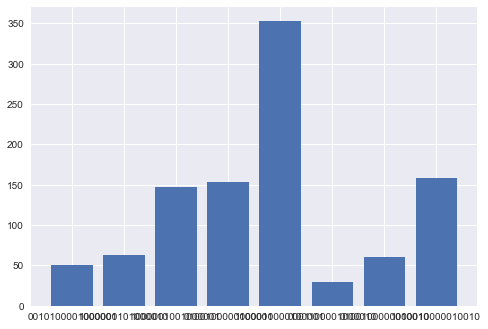

In [32]:
plt.bar(first.keys(),first.values()).patches[0].set_height(50)

(array([1., 1., 1., 0., 1., 1., 0., 1., 1., 1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

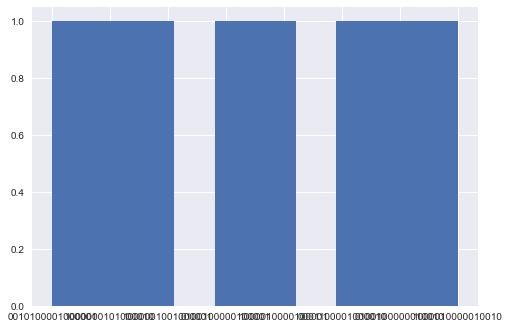

In [19]:
fig,ax = plt.subplots()
ax.hist(first)

AttributeError: module 'matplotlib.pyplot' has no attribute 'clear'

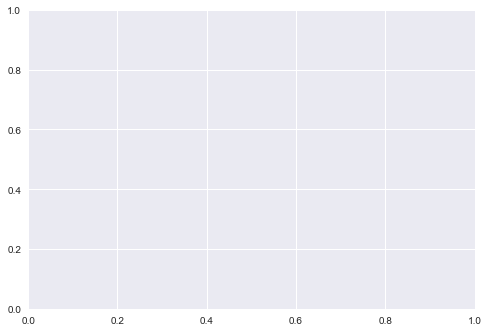

In [25]:
plt.subplots()
for iteration in alternating_operator_counts:
    plt.clear()
    plt.hist(filter_unique_paths(G,iteration))

hi


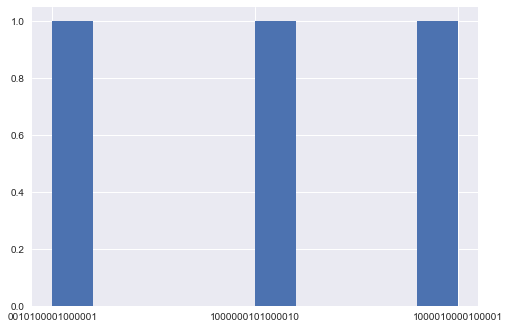

In [22]:
def build_hist():
    plt.figure()
    
    def update_hist(step):
        print('hi')
        #plt.cla()
        data = alternating_operator_counts[step]
        filter_unique_paths(G,data)
        plt.hist(filter_unique_paths(G,data))

update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=50)
plt.show()

In [76]:
len(alternating_operator_counts)

50

In [20]:
plt.figure()
    
def update_hist(step):
        print('hi')
        #plt.cla()
        data = alternating_operator_counts[step]
        plt.hist(filter_unique_paths(G,data))

update_hist(0)
anim = animation.FuncAnimation(fig, update_hist, frames=50)
plt.show()

hi


NameError: name 'filter_unique_paths' is not defined

<Figure size 576x396 with 0 Axes>

In [91]:
build_hist()

<Figure size 432x288 with 0 Axes>

TypeError: '<' not supported between instances of 'Counts' and 'float'

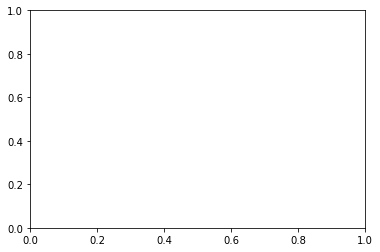

In [70]:
fig,ax = plt.subplots()
_, _, bar_container = ax.hist(alternating_operator_counts)



def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = alternating_operator_counts[frame_number]
        for bitstring_count, rect in zip(data.items(), bar_container.patches):
            print(bitstring_count)
            rect.set_height(bitstring_count[1])
        return bar_container.patches
    return animate

In [69]:
ani = animation.FuncAnimation(fig, prepare_animation(bar_container),
                              repeat=False, blit=True)

('0010100001000001', 59)
('1000000101000010', 63)
('1000001001000001', 147)
('0100100000100001', 154)
('1000010000100001', 353)
('0001100001000010', 29)
('0100100000010010', 61)
('1000010000010010', 158)
('0010100001011101', 200)


In [67]:
plt.show()

In [53]:
for i in a.items():
    print(i)

('0010100001000001', 59)
('1000000101000010', 63)
('1000001001000001', 147)
('0100100000100001', 154)
('1000010000100001', 353)
('0001100001000010', 29)
('0100100000010010', 61)
('1000010000010010', 158)
('0010100001011101', 200)


In [44]:
a['0010100001011101'] = 200

In [45]:
a

{'0010100001000001': 59,
 '1000000101000010': 63,
 '1000001001000001': 147,
 '0100100000100001': 154,
 '1000010000100001': 353,
 '0001100001000010': 29,
 '0100100000010010': 61,
 '1000010000010010': 158,
 '0010100001011101': 200}

In [33]:
a = alternating_operator_counts[0]

In [46]:
filter_unique_paths(G,a)

{'0010100001000001': 371,
 '1000000101000010': 210,
 '1000010000100001': 443,
 'invalid': 200}

In [3]:
import matplotlib

In [6]:
matplotlib.rcParams['animation.writer']

'avconv'

In [43]:
with open("alternating_operator_counts", "rb") as fp:   # Unpickling
    a = pickle.load(fp)

In [53]:
new = {}
for b in a:
    for bitstring,count in b.items():
        if bitstring not in new:
            new[bitstring] = cost(G,bitstring_to_path(bitstring))

In [60]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%d-%m-%Y_%H-%M"))


Current date and time : 
17-06-2022_17-11


In [56]:
filter_unique_paths(G,dict(sorted(new.items(), key=lambda item: item[1])))

{'1000000100010000000100010': 230.84228405063354,
 '1000000001010000010000010': 255.96039159901335,
 '1000000010010000010000001': 268.16691794839306,
 '1000000100010000001000001': 272.9595497165726,
 '1000001000000010010000010': 585.9896240268349,
 '0010010000010000000100010': 595.5748875631941,
 '1000001000001000000100010': 606.1257010449735,
 '0100010000001000000100010': 619.9879402619536,
 '1000001000001000001000001': 665.9471796780922,
 '1000001000000100010000001': 670.2241553587132}

In [54]:
new

{'1000001000001000000100010': 303.0628505224867,
 '0001010000010000010000001': 303.06285052248677,
 '1000000010010000010000001': 268.16691794839306,
 '1000001000000010010000010': 292.99481201341746,
 '0100010000000100010000001': 292.99481201341746,
 '1000001000001000001000001': 332.9735898390461,
 '0100010000001000000100010': 309.9939701309768,
 '1000001000000100010000001': 335.11207767935656,
 '1000000100010000001000001': 272.9595497165726,
 '0100010000000010010000010': 335.1120776793566,
 '0010010000010000000100010': 297.78744378159706,
 '0100010000001000001000001': 297.78744378159706,
 '0010010000010000001000001': 309.9939701309768,
 '1000000100010000000100010': 230.84228405063354,
 '0000110000010000010000010': 332.97358983904616,
 '1000000001010000010000010': 255.96039159901335}